In [16]:
import importlib
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from sklearn.metrics import r2_score

frac=100

# Import data till 7th April

In [17]:
data=pd.read_csv("maha_data7apr.csv")
real_P=data["Total Cases"]-data["Total Deaths"]-data["Total Recoveries"]
real_t=list(range(0,len(real_P)))
date=list(data["Date"])

# The Function

In [18]:
def f(beta,beta1,x0,t):
    def sirx(x,t):
        #import the values
        S,E,A,I,Xs,Xe,Xa,Xi,P,R=x

        #Parameters
        beta2=0.1
        b1=beta1
        b2=0.1*beta1
        b3=0.002*beta1
        k0=1/7
        kt=0.06125
        mu=1/7
        sigma=1/5
        gamma1=1/19
        gamma2=1/14
        gamma3=1/14
        f=0.1

        lkdwn_start1=[date.index(lkdwn_start)]
        lkdwn_end1=[lkdwn_end]
        lkdwn_start1.append(days)

        #For heavyside function
        for j in range(len(lkdwn_end1)):
            if t>lkdwn_end1[j] and t<lkdwn_start1[j+1]:
                theta=1
                break
            else:
                theta=0
        #For Pulse function
        for j in range(len(lkdwn_end1)):
            if t>lkdwn_start1[j] and t<lkdwn_end1[j]:
                zi=1
                break
            else:
                zi=0

        com=beta*(I+A+(b1*Xa)+(b2*Xi)+(b3*P)+beta2*(E+beta1*Xe))

        #THE EQUATIONS
        dSdt = -(com*S/N) - (zi*k0*S) + (theta*mu*Xs)
        dEdt = (f*com*S/N) - (gamma1*E)
        dAdt = ((1-f)*com*S/N) - (sigma*A) - (zi*k0*A) + (theta*mu*Xa)
        dIdt = (sigma*A) - (kt*I) - (zi*k0*I) + (theta*mu*Xi) - (gamma2*I)                              
        dXsdt = -(beta1*com*Xs/N) + (zi*k0*S) - (theta*mu*Xs)
        dXedt = (f*beta1*com*Xs/N) - (gamma1*Xe)
        dXadt = ((1-f)*beta1*com*Xs/N) - (sigma*Xa) + (zi*k0*A) - (theta*mu*Xa)
        dXidt = (sigma*Xa) - (kt*Xi) + (zi*k0*I) - (theta*mu*Xi) - (gamma2*Xi)
        dPdt = (kt*(I+Xi)) - (gamma3*P)
        dRdt = (gamma2*(I+Xi)) + (gamma3*P) + gamma1*(E + Xe)

        return [dSdt,dEdt,dAdt,dIdt,dXsdt,dXedt,dXadt,dXidt,dPdt,dRdt]
    x=odeint(sirx,x0,t)
    
    return x

# Initial values of the Variables

In [19]:
days=25
N=1.142e8  #Total population of Maharashtra
E0=25
A0=25
I0=25
S0=N-E0-A0-I0
lkdwn_start="24-Mar"
lkdwn_end=days
x0=[S0,E0,A0,I0,0,0,0,0,0,0]
t=np.linspace(0,days,(days*frac + 1))

# Makes Goodness of fit against beta

In [20]:
fit=[]
betas=[]
for i in range(101):
    beta=i/100
    betas.append(beta)
    x=f(beta,0.1,x0,t)
    P=x[:,8]
    fit.append(chisquare(P[frac::frac],f_exp=real_P)[0])

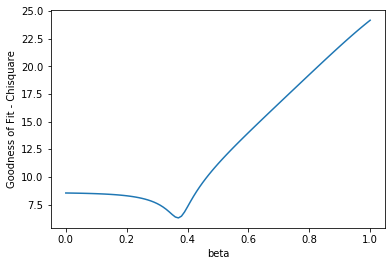

In [21]:
plt.plot(betas,np.log(fit))
plt.xlabel('beta')
plt.ylabel('Goodness of Fit - Chisquare')
plt.show()

In [22]:
min_val=min(fit)
index=list(fit).index(min_val)
print(betas[index])

0.37


# Grid search for best beta and beta1

In [118]:
fit=[]
beta=np.linspace(0.,1.,101)
#beta=0.3258
beta1=np.linspace(0.,1.,101)
mini=10000000000000000000000
for i in beta:
    for j in beta1:
        x=f(i,j,x0,t)
        P=x[:,8]
        val=chisquare(P[frac::frac],f_exp=real_P)[0]
        fit.append(val)
        if val<mini:
            mini=val
            best_beta=i
            best_beta1=j
print(best_beta,best_beta1)

0.33 0.86


In [119]:
min_val=min(fit)
index=fit.index(min_val)
x=f(best_beta,best_beta1,x0,t)
P=x[:,8]
val=chisquare(P[frac::frac],f_exp=real_P)[0]
print(index,min_val,val)

3419 334.11783338709824 334.11783338709824


# Plot P vs t for further dates

In [12]:
data=pd.read_csv("maha_data7apr.csv")
real_P=data["Total Cases"]-data["Total Deaths"]-data["Total Recoveries"]
real_P=real_P.values
real_t=list(range(0,len(real_P)))
date=list(data["Date"])
real_PP=list(real_P)

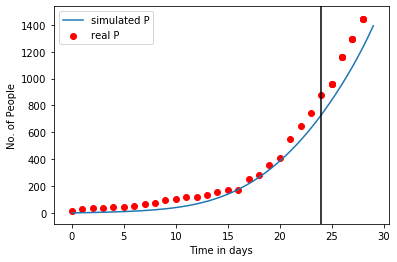

In [137]:
real_PP.extend([962,1158,1293,1443])
real_t.extend([25,26,27,28])
days=29
t=np.linspace(0,days,(days*frac + 1))
x=f(best_beta,best_beta1,x0,t)
P=x[:,8]
plt.plot(t,P,label='simulated P')
plt.axvline(x=24,color='black')
plt.scatter(real_t,real_PP,color='r',label='real P')
plt.xlabel('Time in days')
plt.ylabel('No. of People')
plt.legend()
plt.show()

# best fit beta is 0.3285,beta1=0.89

# 3D Plotting

In [23]:
all_fit=[]
x=y=np.linspace(0.,1.,101)
for i in x:
    for j in y:
        x=f(i,j,x0,t)
        P=x[:,8]
        fit=chisquare(P[frac::frac],f_exp=real_P)[0]
        all_fit.append([i,j,fit])

In [24]:
all_fit=np.array(all_fit)
z=all_fit[:,2]
x=y=np.linspace(0.,1.,101)
X,Y=np.meshgrid(x,y)
zz=z.reshape(101,101)

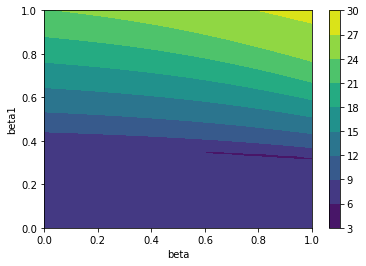

In [25]:
plt.contourf(X,Y,np.log(zz))
plt.xlabel('beta')
plt.ylabel('beta1')
plt.colorbar()
plt.show()

In [92]:
import csv
with open('plot_data.csv','w',newline='') as f:
    fieldnames=['Beta','Beta1','Chisquare']
    thewriter=csv.DictWriter(f,fieldnames=fieldnames)
    thewriter.writerow({'Beta':'Beta','Beta1':'Beta1','Chisquare':'Chisquare'})
    for i in range(len(pred)):
        thewriter.writerow({'Beta':all_fit[i][0],'Beta1':all_fit[i][1],'Chisquare':all_fit[i][2]})

559


In [26]:
all_fit=[]
x=np.linspace(0.2,0.4,201)
y=np.linspace(0.6,1.,401)
for i in x:
    for j in y:
        x=f(i,j,x0,t)
        P=x[:,8]
        fit=chisquare(P[frac::frac],f_exp=real_P)[0]
        all_fit.append([i,j,fit])

In [27]:
all_fit=np.array(all_fit)
z=all_fit[:,2]
x=np.linspace(0.3,0.4,201)
y=np.linspace(0.6,1.,401)
X,Y=np.meshgrid(x,y)

In [28]:
zz=z.reshape(401,201)

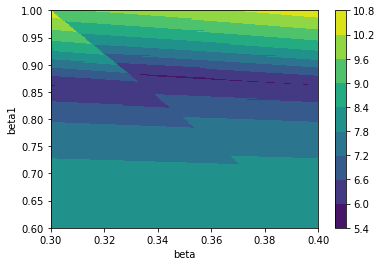

In [30]:
plt.contourf(X,Y,np.log(zz))
plt.xlabel('beta')
plt.ylabel('beta1')
plt.colorbar()
plt.show()